### **Importing Related Notebooks**

In [2]:
import import_ipynb
import Feature_Engineering
import Hyperparameter_Tuning

data = Feature_Engineering.data
mapping = Feature_Engineering.mapping
num_preprocessor = Feature_Engineering.num_preprocessor
X_train = Feature_Engineering.X_train
y_train = Feature_Engineering.y_train
best_model = Hyperparameter_Tuning.best_model
X_trainval = Hyperparameter_Tuning.X_trainval
y_trainval = Hyperparameter_Tuning.y_trainval
best_model = Hyperparameter_Tuning.best_model

### **Model Explanation**

Model explanation refers to the process of understanding and explaining how the algorithm model works in making predictions. The goal is to provide insights and find out what factors contribute to the output produced. In this case, a number of features are provided from past data regarding customer information using the company's services and labels that reflect the subscription status of each customer. The company wants to know what factors cause a customer to churn and evaluate existing business models with the aim that customer retention can be as high as possible. Here are some reasons why a model explanation is needed, including:

1. **Trust and Accountability**: Understanding how an algorithmic model makes predictions will build trust in users, stakeholders, and related institutions. Model explanation guarantees transparency and provides insights about what factors affect the output of the algorithm model.

1. **Insights and Understanding**: Model explanation helps humans understand complex algorithmic models by identifying which features are most influential in making predictions. In addition, insights will be provided about the relationships and patterns studied by the algorithmic model thereby helping domain experts to gain a deeper understanding of a problem.
1. **Debugging and Error Analysis**: Model explanation can help diagnose and improve the behavior of model algorithms. By explaining the reasons behind specific predictions, it will be possible to identify biases, errors, and limitations in the algorithmic model. This information will be very valuable in improving the performance of the algorithm model in dealing with existing issues.

In doing model explanation, **Shapley** values ​​will be used which is a concept from cooperative game theory. Complete documentation of library **Shap** can be found at [following link](https://github.com/slundberg/shap/tree/master).

In [3]:
import shap
shap.initjs()

The library has a weakness because it can only use the estimator from the algorithm model directly that has been carried out by the learning process on training data. Therefore, it is necessary to describe the model learning process again without using pipeline.

In [4]:
from imblearn.over_sampling import RandomOverSampler

X_resampled, y_resampled = RandomOverSampler(random_state=1995).fit_resample(
    X=X_trainval,
    y=y_trainval
)

model = best_model.named_steps['model'].fit(
    X=X_resampled,
    y=y_resampled
)

explainer = shap.Explainer(model=model)
shap_values = explainer(X_resampled)

##### **Feature Importance**

Next, a visualization will be carried out to find feature importance of the existing features based on the quantification of the **Shapley** value.

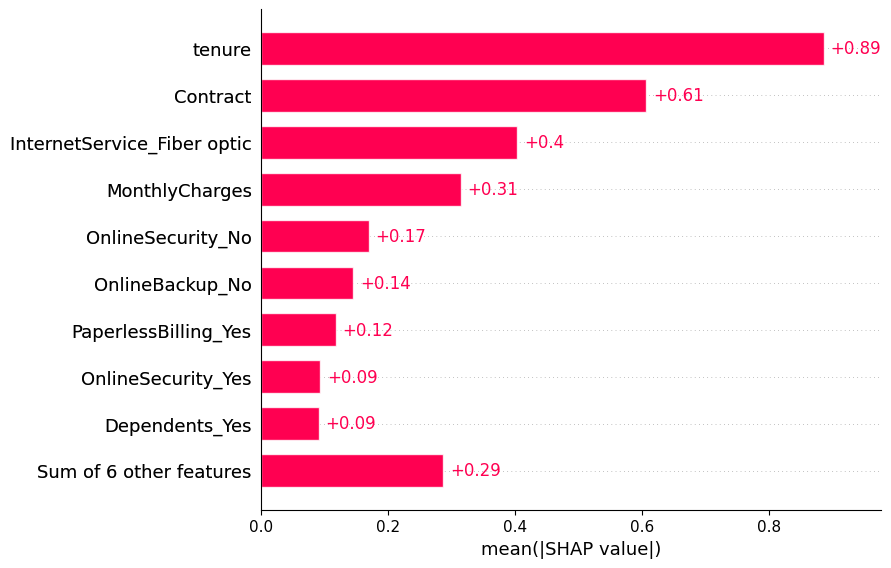

In [5]:
shap.plots.bar(
    shap_values,
    show=False
)

It can be seen that there are 4 most influential features in predicting customers who churn or not, including `tenure`, `Contract`,  `InternetService_Fiber optic`, and `MonthlyCharges` respectively. The other features have very little contribution in determining the final prediction result.

This Shapley value basically only measures the average contribution of each feature from all observations and predictions made by **Gradient Boosting** which have gone through resampling and hyperparameter tuning processes. As a result, the model will have limitations in interpreting some of the features that are considered not so important for their contribution but participate in producing the probability prediction of an observation. This is reasonable because there are some observations that behave out of character in general so that they fall into edge cases. Although basically, the number of observations is not that many or significant.

Therefore, further examination is needed in outline to understand the pattern of the **Gradient Boosting** algorithm model that has been built.

##### **Prediction and Feature Relationship**

Next, a visualization will be carried out to see the relationship between the various features on the possibility of churn customers globally.

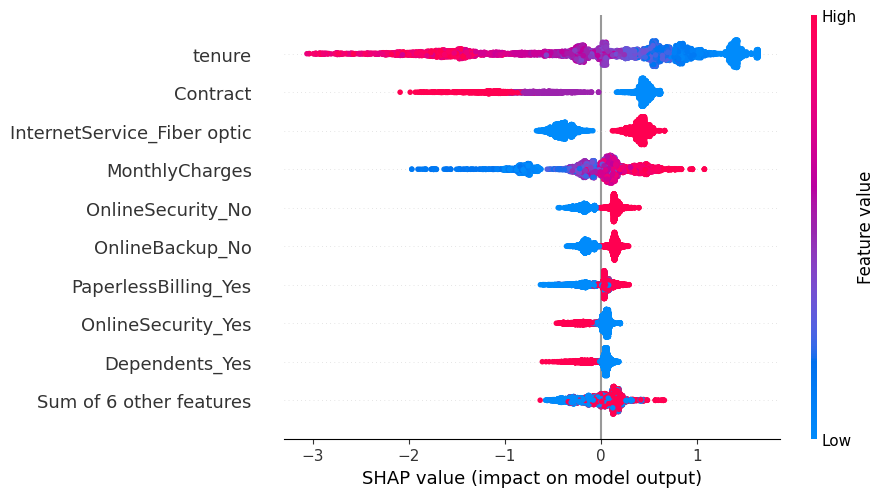

In [6]:
shap.plots.beeswarm(
    shap_values,
    show=False
)

It can be seen that there is a clear relationship regarding the quantified probability based on the Shapley value. The explanation can be described as follows:

1. A `tenure` feature with a greater value, indicated by a redder color, has a smaller Shapley value and vice versa, with a smaller `tenure` feature value, the Shapley value will get bigger. This represents that customers with a short subscription duration, or in other words, new customers, have a high tendency to churn. This statement is in line with the insights obtained in the previous discussion in the Explanatory Data Analysis section. Even so, there are some cases that are difficult to predict as seen from the Shapley value which is around the zero value. In the graph, it can be seen that some of the `tenure` feature values, whether high, medium or low, converge in the zero mean area.

1. The `Contract` feature with an increasing value, respectively `Month-to-month`, `One year` and `Two year`, has a tendency to continue to subscribe based on output of negative Shapley values. Negative values ​​will contribute to the overall resulting probability value so that the value will be smaller and the probability of churn will be smaller. This statement is in line with the insights obtained in the previous discussion in the Explanatory Data Analysis section. It can be seen that there is a clearer distribution separation of Shapley values ​​where the `Month-to-month` category is in the positive area, while the `One year` and `Two year` categories are in the negative area. This means that customers who take `Month-to-month` contracts will be considered by the algorithm model as causing churn while those who take others will be considered as causing customers to be loyal.
1. The `InternetService_Fiber optic` feature is categorical in nature, which can be represented as a customer using the `Fiber optic` service in the `InternetService` feature which has a tendency to churn on a relatively insignificant scale. This can be used as an additional evaluation for the company to identify other related factors such as service quality and prices that are deemed inappropriate for the service.
1. The `MonthlyCharges` feature, with a higher value, will produce a larger Shapley value. This means that the price affects the possibility of customers to churn. The higher the monthly bill, the greater the possibility to churn. This statement is in line with the insights obtained in the previous discussion in the Explanatory Data Analysis section. Even so, there are some cases that are difficult to predict based on the value of Shapley which is around the zero value. In this case, the algorithm model assesses the `MonthlyCharges` feature as not having sufficient significance to predict customers who churn or not, although in general cases this feature does have significance.
1. Other features can be described in a similar way but will not be discussed in more depth considering that the contribution made to the churn probability of a customer is very small.

The explanation above can be used as a form of generalization and does not have to happen in every local instances or observation. Next, a visualization will be carried out to see the relationship between Shapley values ​​in each value of the `MonthlyCharges`, `tenure`, `Contract`, and `InternetService_Fiber optic` features based on customers who churn and are still subscribing.

Text(0.5, 0.98, 'Shap and Feature Values Relationship')

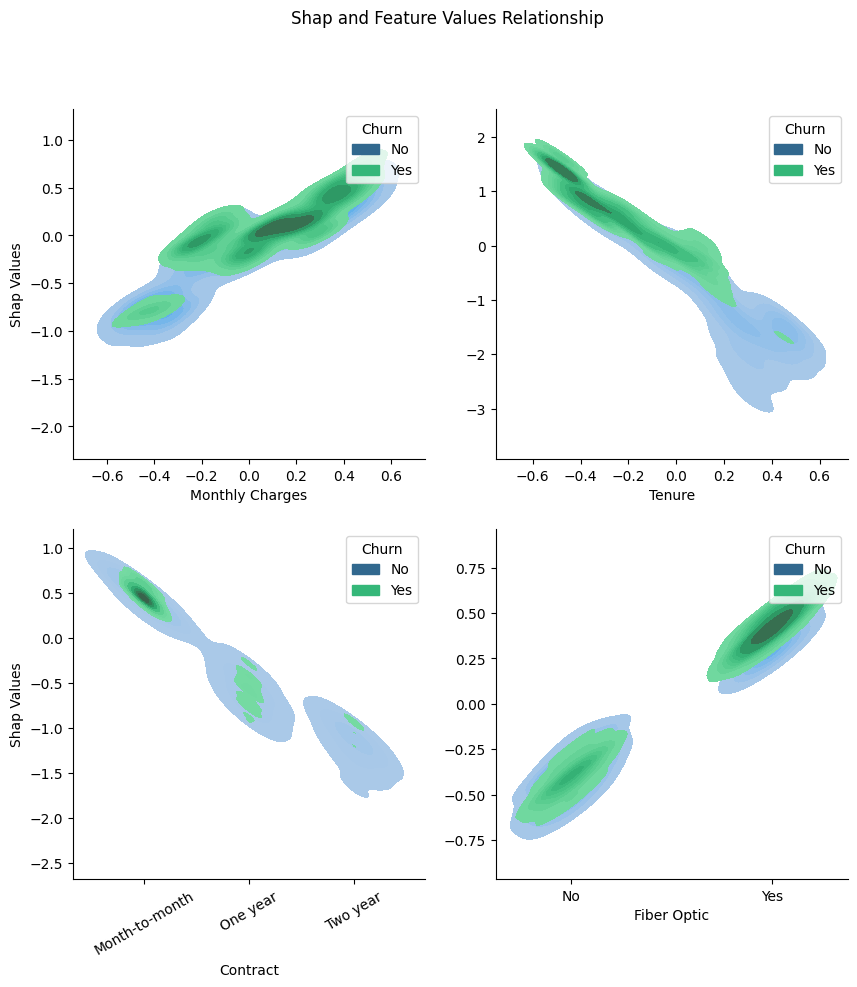

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

translate = lambda x: 'Yes' if x == 1 else 'No'
ticker_dict = {
    2:[
        [0,1,2],
        ['Month-to-month','One year','Two year']
    ],
    3:[
        [0,1],['No','Yes']
    ]
}

fig, axs = plt.subplots(
    figsize=(10,10),
    ncols=2,
    nrows=2,
    gridspec_kw={'wspace':0.2}
)

for i, var in enumerate(list(range(-1,-4,-1))+[1]):
    sns.kdeplot(
        y=shap_values.values[:,var],
        x=shap_values.data[:,var],
        hue=y_resampled.apply(translate),
        ax=axs[0 if i < 2 else 1,i if i < 2 else i%2],
        palette='viridis',
        fill=True
    )

    if i >= 2:
        axs[1,i%2].set_xticks(
            ticks=ticker_dict.setdefault(i)[0],
            labels=ticker_dict.setdefault(i)[1],
            rotation=30 if i == 2 else 0
        )

    axs[0 if i < 2 else 1,i if i < 2 else i%2].set_xlabel(
        'Monthly Charges' if i == 0 else 
        'Tenure' if i == 1 else 
        'Contract' if i == 2 else
        'Fiber Optic'
    )

    sns.despine()

axs[0,0].set_ylabel('Shap Values')
axs[1,0].set_ylabel('Shap Values')
fig.suptitle('Shap and Feature Values Relationship')

It can be seen that the higher the monthly bill, the greater the contribution to the possibility of a customer churn and vice versa when viewed from the duration of the subscription. The subscription duration is directly related to the type of contract used so customers who take a `Month-to-month` contract will have a greater tendency to churn compared to `One year` and `Two year` contracts. In addition, as we know previously, customers who use `Fiber optic` tend to churn yet this circumstances don't apply in general.

In the context of the interpretability of the algorithm model, the Shapley value measures the contribution of each feature in making predictions in each observational data. This method is done by distributing credit or importance from each feature among other features fairly. Key idea behind Shapley value is to consider all possible feature combinations and calculate the marginal contribution of each
feature when added to a mix of other features. By taking the average value of the existing contributions to all possible feature combinations, you will get Shapley values ​​for each feature.

##### **Model Limitation**

As previously explained, the **Gradient Boosting** algorithm model that has been built is very good at predicting churn customers and generalizing existing datasets. Even so, this algorithm model has limitations in some cases that are difficult to predict. This has also been stated in the Explanatory Data Analysis section and a number of observational samples will be seen that are included in the edge cases section. 

There are several conditions that will be used to classify the observation sample which includes edge cases, one common approach is to get the sum of Shapley values from all features in each observation that is around zero.

In [8]:
import pandas as pd

shap_df = pd.DataFrame(shap_values.values)
shap_df['sum'] = shap_df.apply(
    func=lambda x: sum(x),
    axis=1
)

edge_cases = X_resampled.iloc[shap_df[
    (shap_df['sum']>-0.05) &
    (shap_df['sum']<0.05)
].index.values]

print('There are {} extreme edge cases.'.format(len(edge_cases)))

There are 33 extreme edge cases.


At least 33 observation samples were found which were considered the most extreme edge cases. In these cases it is certain that the **Gradient Boosting** algorithm model will have very wrong prediction results because the features that generally have a large contribution have turned into decisive features.

In [9]:
for i in edge_cases.drop(['tenure','MonthlyCharges'],axis=1):
    edge_cases[i] = edge_cases[i].astype(str)

top_df = edge_cases.describe(include='object').transpose()
top_df['pct'] = top_df[['count','freq']].apply(
    func=lambda x: round(
        number=int(x[1])/int(x[0])*100,
        ndigits=2
    ),
    axis=1
)

top_df[top_df['top']=='1'].append(top_df.loc[[
    'Contract',
    'InternetService_Fiber optic'
]]).sort_values(
    by='pct',
    ascending=False
)

,count,unique,top,freq,pct
DeviceProtection_No,33,2,1,27,81.82
TechSupport_No,33,2,1,26,78.79
Contract,33,2,0,26,78.79
PaperlessBilling_Yes,33,2,1,24,72.73
InternetService_DSL,33,2,1,22,66.67
InternetService_Fiber optic,33,2,0,22,66.67
Dependents_Yes,33,2,1,21,63.64
OnlineBackup_No,33,2,1,20,60.61
OnlineSecurity_No,33,2,1,18,54.55


Based on descriptive statistics above, we see modes of class concurrence in other features when the sum of Shapley values accross all features is around zero. In `pct` column, we can see the proportion of modes to obtain slight ideas of how often the such class come up in terms of model limitation. Then an examination process will be carried out on the 5 observation samples that fall into the edge cases category.

In [10]:
for i in edge_cases.drop_duplicates().head().index.values:
    display(shap.force_plot(shap_values[i]))

It can be seen that in the 5 examples of edge cases above, the relationship given to the prediction results can be seen based on color, where red makes a positive contribution to customers who churn and blue makes a negative contribution or vice versa. The cumulative Shapley value obtained is also in the range of base values, which is -0.304 indicating that these observation samples cause the developed **Gradient Boosting** algorithm model to produce predictions that are not much different from the original guess or random prediction.

The analysis process in this way can be used by companies to detect which cases are considered edge cases so that an additional, more in-depth approach is needed besides using the **Gradient Boosting** algorithm model which was built to make predictions.

### **Model Saving**

Algorithmic models need to be trained on all existing datasets, both training, validation, and test data with the aim of being stored as the final model. Prior to that, it is necessary to redefine the pipeline flow for the final model as a whole because it has a different treatment from the previous processes. Among them is not going through the splitting process with method `train_test_split()` and also not going through the data preprocessing for the entire dataset without worrying about information leakage. In addition, the feature selection process must also be structured in such a way that the process will be executed automatically and in accordance with the feature engineering in the previous section. Thus, additional functional assistance is needed to handle the process.

First of all, the entire dataset will be split into features and target by separating the columns.

In [11]:
import numpy as np

X_data = data.drop('Churn',axis=1)
y_data = data['Churn']
y_data = np.where(y_data=='Yes',1,0)

Then, a pipeline will be defined which covers the entire process starting from binning, scaling, encoding, feature selection, resampling, and modeling.

In [12]:
from sklearn.pipeline import Pipeline as pl
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from category_encoders import OrdinalEncoder

import pandas as pd

transformer = ColumnTransformer([
    (
        'multiclass_onehot',
        OneHotEncoder(),
        ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']
    ),
    (
        'binary_onehot',
        OneHotEncoder(drop='if_binary'),
        ['Dependents','PaperlessBilling']
    ),
    (
        'ordinal',
        OrdinalEncoder(mapping=mapping),
        ['Contract']
    ),
    (
        'num_preprocessor',
        num_preprocessor,
        ['tenure','MonthlyCharges']
    )
],
remainder='passthrough')

def feature_selection(X_data):
    feature_names = [
        'InternetService_DSL','InternetService_Fiber optic','InternetService_No',
        'OnlineSecurity_No','OnlineSecurity_No internet service','OnlineSecurity_Yes',
        'OnlineBackup_No','OnlineBackup_No internet service','OnlineBackup_Yes',
        'DeviceProtection_No','DeviceProtection_No internet service','DeviceProtection_Yes',
        'TechSupport_No','TechSupport_No internet service','TechSupport_Yes',
        'Dependents_Yes',
        'PaperlessBilling_Yes',
        'Contract',
        'tenure',
        'MonthlyCharges'
    ]

    df = pd.DataFrame(
        data=X_data,
        columns=feature_names
    )

    df = df.drop(columns=[
        'InternetService_No',
        'OnlineSecurity_No internet service',
        'OnlineBackup_No internet service',
        'DeviceProtection_No internet service',
        'TechSupport_No internet service'
    ])

    return df

preprocessor = pl([
    ('transformer',transformer),
    ('feature_selection',FunctionTransformer(func=feature_selection))
])

estimator = pl([
    ('preprocessor',preprocessor),
    ('model',best_model)
])

Furthermore, the final model will be stored with the help of library **pickle**.

In [13]:
import pickle

final_model = estimator.fit(X_data,y_data)

with open('Final_Model.sav', 'wb') as file:
    pickle.dump(final_model,file)